Same as curve_fit but implented train-test-split for the sinusoidal fit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
# import celerite
# from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *

In [2]:
SONG = np.loadtxt('./lib/sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

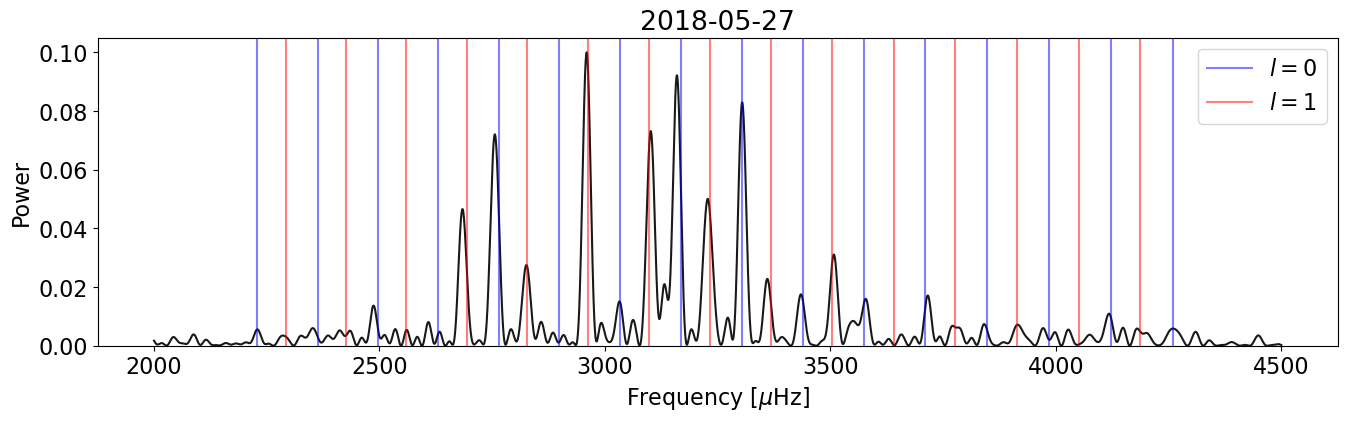

In [3]:
f0 = [2228.779, 2362.831, 2496.237, 2629.741, 2764.233, 2899.133, 3033.886, 3168.773, 3303.698, 3439.195, 3575.121, 3710.972, 3847.277, 3984.527, 3984.527+137.25, 3984.527+137.25*2]
f1 = [2292.035, 2425.655, 2559.242, 2693.450, 2828.279, 2963.478, 3098.327, 3233.358, 3368.721, 3504.417, 3640.799, 3777.430, 3913.974, 3913.974+136.544, 3913.974+136.544*2]
freq = np.hstack((np.array(f0), np.array(f1)))

def plot_osc_freq():
    alpha = 0.5
    for x in f0:
        plt.axvline(x = x, color = 'b', alpha=alpha, label=r'$l=0$' if x==f0[0] else '')
    for x in f1:
        plt.axvline(x = x, color = 'r', alpha=alpha, label=r'$l=1$' if x==f1[0] else '')
    plt.legend()
    
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

fig = plt.figure(figsize=(16, 4))
plt.rcParams.update({'font.size': 16})

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)

    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    delta_t = max(t) - min(t)
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.5
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    x = np.linspace(min(t), max(t), 2000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)   
    
    frequency, power = LombScargle(x*60, pred_mean).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
    frequency *= 1e6
    idx = ((frequency<4500) & (frequency>2000))
    plt.title(str(date)[:10])
    plt.plot(frequency[idx], power[idx], 'k', alpha=0.9)
    plt.xlabel(r'Frequency [$\mu$Hz]')
    plt.ylabel('Power')
    plt.ylim(bottom=0)
    
    
    if 0: 
        from scipy.interpolate import CubicSpline
        cs = CubicSpline(frequency, power)
        freq_plot = np.linspace(frequency[idx][0], frequency[idx][-1], 1000)
        plt.plot(freq_plot, cs(freq_plot))

plot_osc_freq()
plt.show()

In [4]:
np.diff(f0), np.diff(f1)

(array([134.052, 133.406, 133.504, 134.492, 134.9  , 134.753, 134.887,
        134.925, 135.497, 135.926, 135.851, 136.305, 137.25 , 137.25 ,
        137.25 ]),
 array([133.62 , 133.587, 134.208, 134.829, 135.199, 134.849, 135.031,
        135.363, 135.696, 136.382, 136.631, 136.544, 136.544, 136.544]))

In [5]:
from scipy.optimize import curve_fit

N = len(freq)*2
string = 'def RV(x,'
for i in range(N):
    string += ('a' + str(i) + ',')
string = string[:-1] + '):'
string += '\n    return RV2(x,'
for i in range(N):
    string += ('a' + str(i) + ',')
string = string[:-1] + ')'    
print(string)

exec(string)
def RV2(x, *args):
    sum = 0
    f2 = freq
    for i in range(int(N/2)):
        sum += (args[2*i]*np.sin(2*np.pi*f2[i]/1e6*x*60) + args[2*i+1]*np.cos(2*np.pi*f2[i]/1e6*x*60))
    return sum

def RV(x,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55,a56,a57,a58,a59,a60,a61):
    return RV2(x,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55,a56,a57,a58,a59,a60,a61)


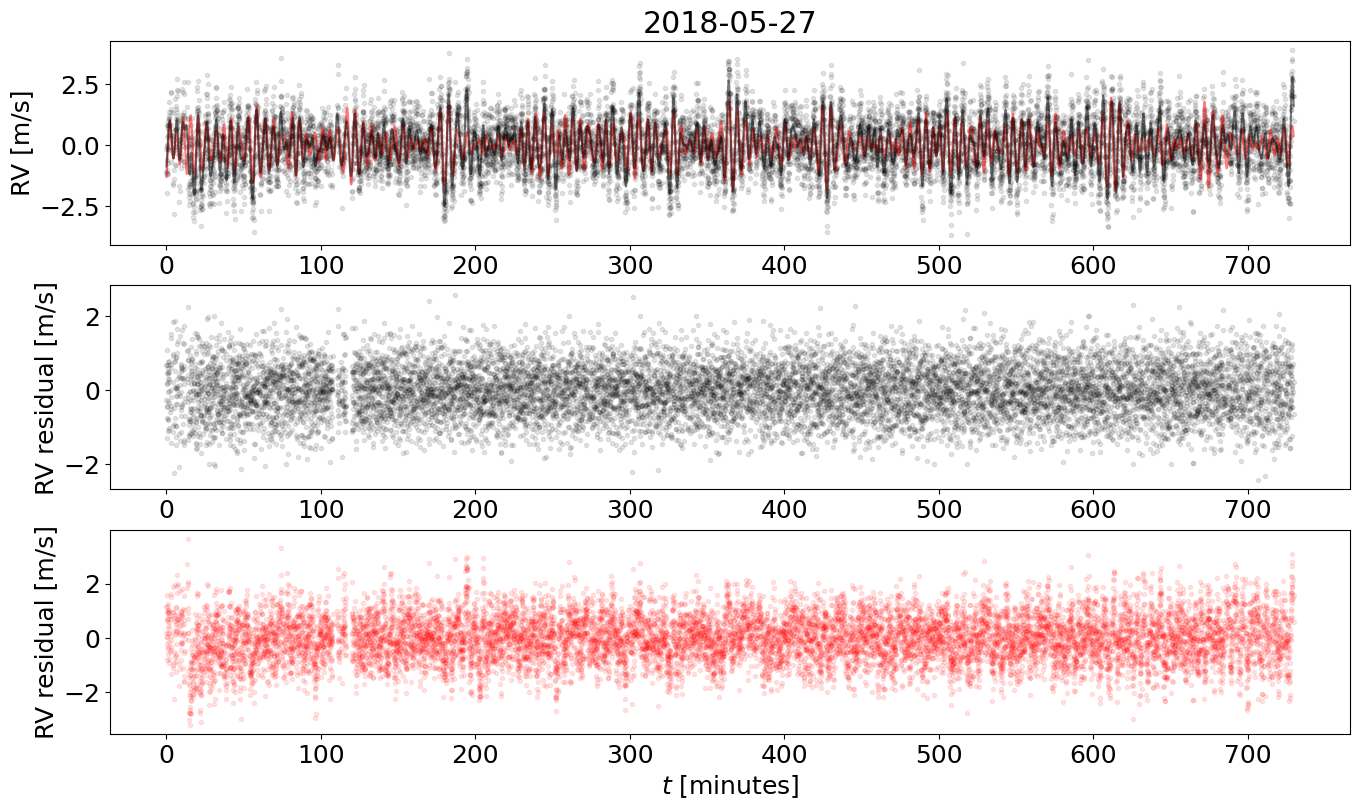

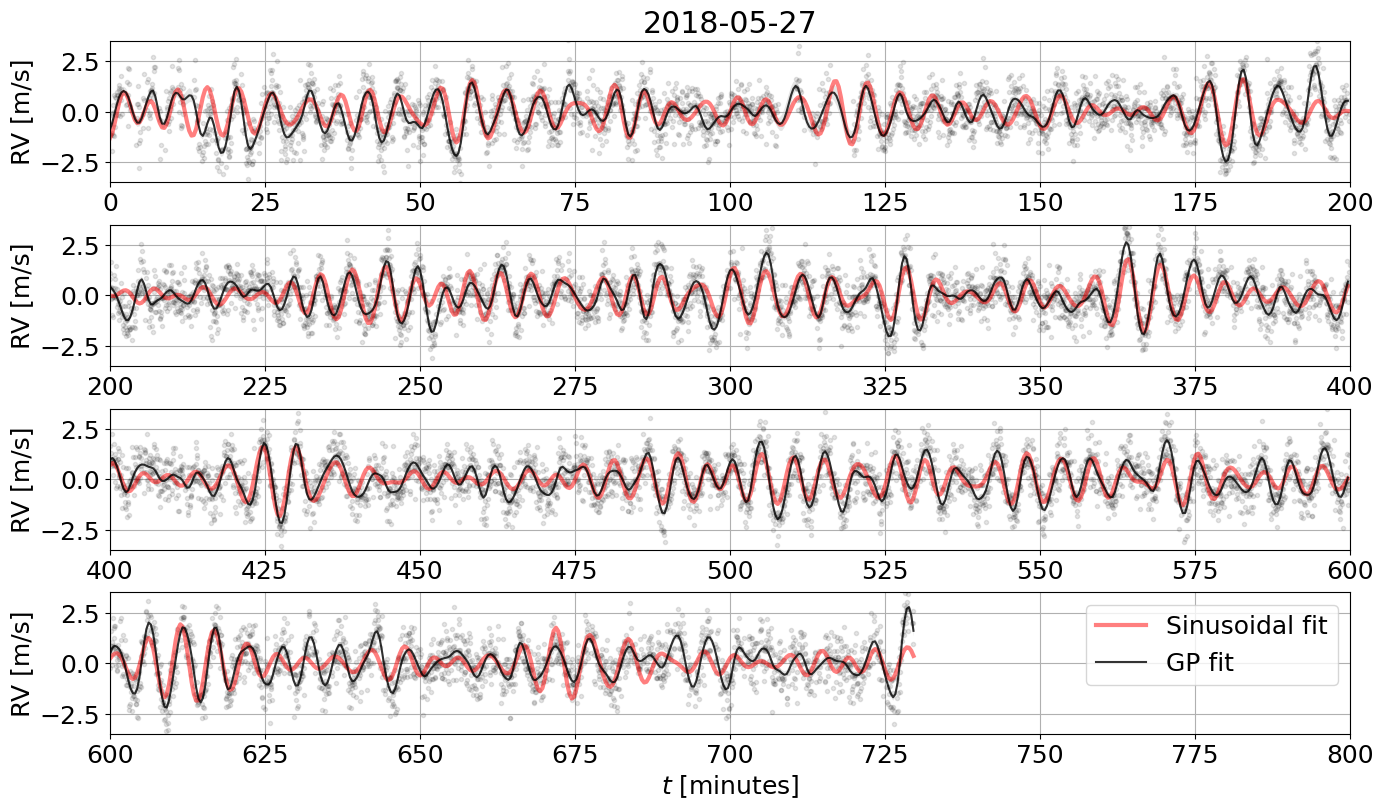

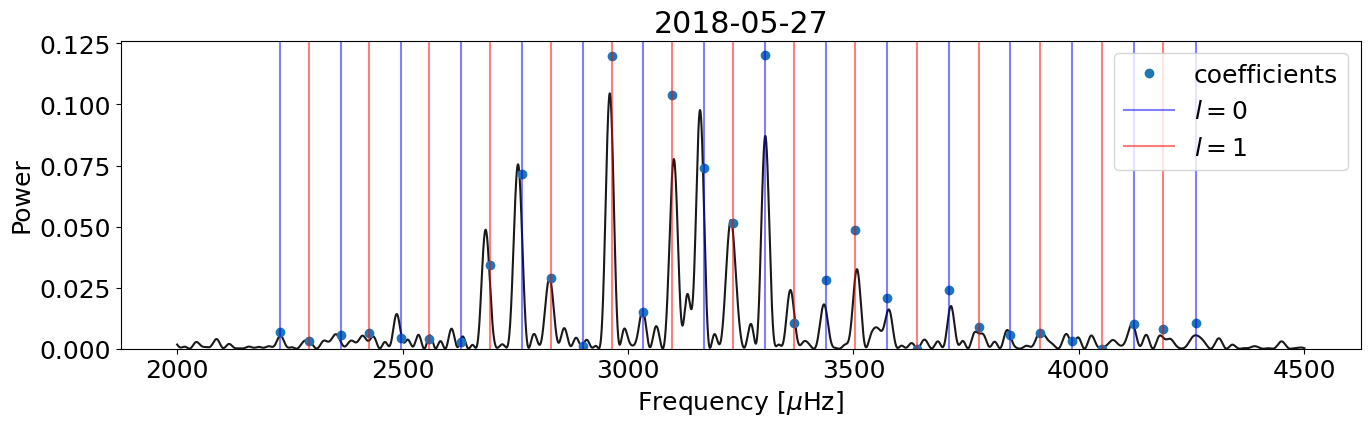

In [16]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.7
    
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    
    exec(string)
    idx_test = ((t > 250) & (t < 300))
    
    popt, pcov = curve_fit(RV, t[~idx_test], y[~idx_test])

    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(16, 9))
    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    x = np.linspace(min(t), max(t), 2000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)       
    plt.plot(t, y, 'k.', alpha=0.1)
    plt.plot(x, RV(x, *popt), 'r', alpha=0.5, label='sine fit')
    plt.plot(x, pred_mean, color='k', alpha=0.5, label='gp: SHO')
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')

    fig.add_subplot(312)
    pred_mean_t, pred_var = gp.predict(y, t, return_var=True)
    plt.plot(t, y-pred_mean_t, 'k.', alpha=0.1)
    plt.ylabel('RV residual [m/s]')

    fig.add_subplot(313)
    plt.plot(t, y-RV(t, *popt), 'r.', alpha=0.1)
    plt.ylabel('RV residual [m/s]')
    plt.xlabel('$t$ [minutes]')
    plt.show()

    
    fig, axs = plt.subplots(4, 1, figsize=(16, 9))
    plt.subplots_adjust(hspace=0.3)
    axs[0].set_title(str(date)[:10])
    for i in range(4):
        idx_t = ((t>=i*200) & (t<(i+1)*200))
        idx_x = ((x>=i*200) & (x<(i+1)*200))
        axs[i].plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
        # axs[i].plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
        axs[i].plot(x[idx_x], RV(x, *popt)[idx_x], 'r', lw=3, alpha=0.5, label='Sinusoidal fit')
        axs[i].plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8, label='GP fit')
        axs[i].fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                         edgecolor="none")
        axs[i].set_ylabel('RV [m/s]')    
        axs[i].set_xlim([i*200, (i+1)*200])
        axs[i].set_ylim([-3.5, 3.5])    
        axs[i].grid(True)
    axs[-1].legend()
    axs[-1].set_xlabel('$t$ [minutes]')
    
    fig = plt.figure(figsize=(16, 4))
    frequency, power = LombScargle(x*60, pred_mean).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
    frequency *= 1e6
    idx = ((frequency<4500) & (frequency>2000))
    coeff = np.sqrt(popt[::2]**2+ popt[1::2]**2)
    plt.title(str(date)[:10])
    plt.plot(frequency[idx], power[idx], 'k', alpha=0.9)
    plt.xlabel(r'Frequency [$\mu$Hz]')
    plt.ylabel('Power')
    plt.plot(freq, coeff**2, 'o', label='coefficients') 
    plt.ylim(bottom=0)
    plot_osc_freq()
    
    plt.show()

In [7]:
np.std(y-RV(t, *popt))

0.8595971215169578

In [8]:
freq = np.sort(freq)


Auto-correlation for the amplitudes 

In [9]:
2*np.pi / (1/(freq*1e-6)/60)

array([0.84022989, 0.86407684, 0.8907663 , 0.91445039, 0.94105918,
       0.9648115 , 0.991389  , 1.01540673, 1.04209129, 1.06623606,
       1.09294739, 1.11720489, 1.14374808, 1.16804176, 1.19459928,
       1.21894725, 1.2454648 , 1.2699779 , 1.29654597, 1.32113408,
       1.34778886, 1.37254889, 1.39900348, 1.42405756, 1.45038926,
       1.47553344, 1.50213129, 1.52700931, 1.55387332, 1.57848519,
       1.60561535])

In [10]:
def GP_fit(t, y, yerr):
    
    S0 = np.var(y) / (2*np.pi/5 * 3*24*60)
    Q = 400
    w0 = 2*np.pi / (1/(freq[0]*1e-6)/60)
    bounds = dict(log_S0=(-20, 15), log_Q=(np.log(300), np.log(500)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    kernel.freeze_parameter("log_omega0")
    
    for fre in freq[1:]:
        w0 = 2*np.pi / (1/(fre*1e-6)/60)
#         print(2*np.pi/w0)
#         bounds = dict(log_S0=(-15, 15), log_Q=(np.log(2*24*60), np.log(4*24*60)))
        k = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
        k.freeze_parameter("log_omega0")
        kernel += k

    gp = celerite.GP(kernel, mean=np.mean(y), fit_white_noise=True)
    gp.compute(t)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    return gp

In [11]:
2*24*60

2880

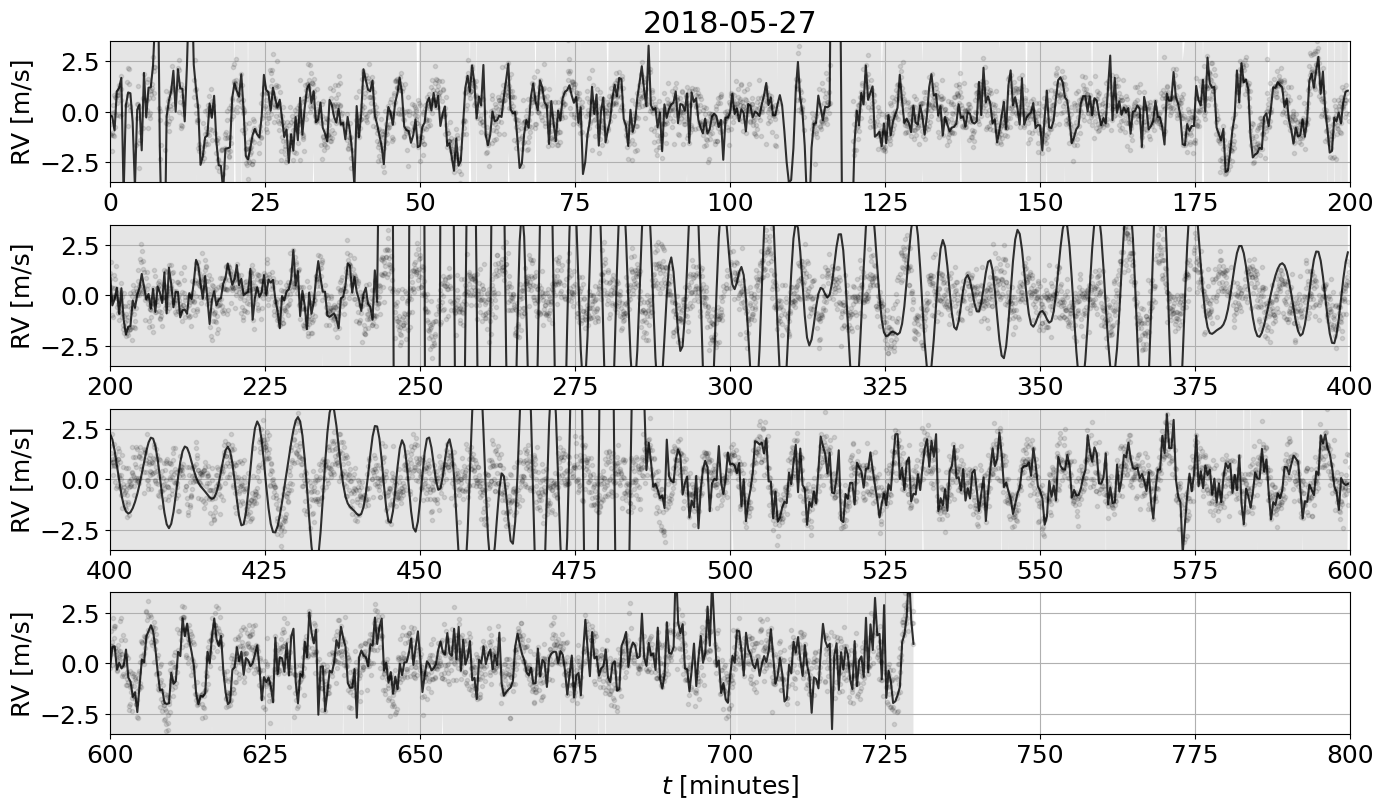

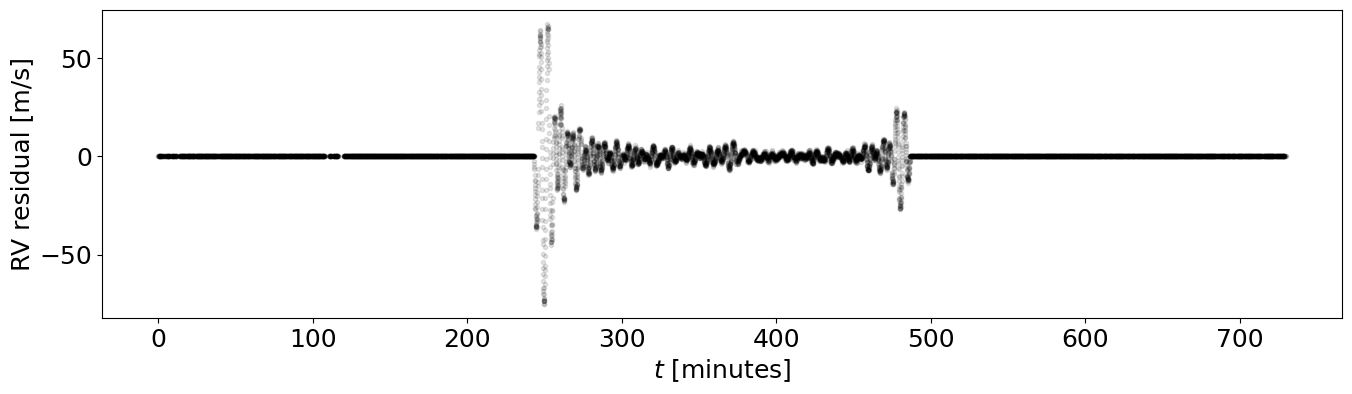

10.885668136364563 1.0503243388873678


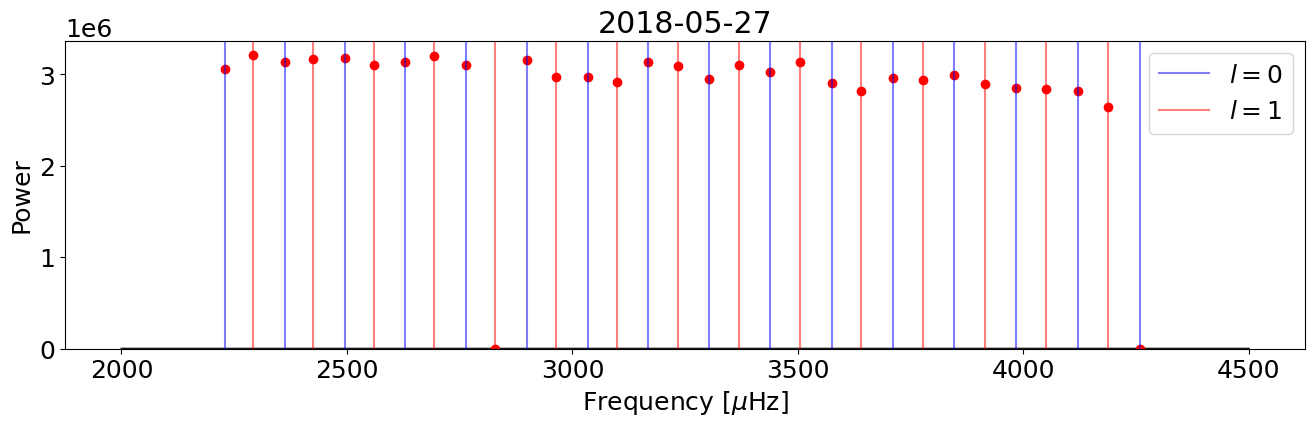

In [12]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.69
    
    idx_train = ((t < max(t)/3) | (t > max(t)/3*2))
    gp = GP_fit(t[idx_train], y[idx_train], yerr[idx_train])
    
    x = np.linspace(min(t), max(t), 2000)
    pred_mean, pred_var = gp.predict(y[idx_train], x, return_var=True)
    pred_std = np.sqrt(pred_var)   

    fig, axs = plt.subplots(4, 1, figsize=(16, 9))
    plt.subplots_adjust(hspace=0.3)
    axs[0].set_title(str(date)[:10])
    for i in range(4):
        idx_t = ((t>=i*200) & (t<(i+1)*200))
        idx_x = ((x>=i*200) & (x<(i+1)*200))
        axs[i].plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
        axs[i].plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
        axs[i].fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                         edgecolor="none")
        axs[i].set_ylabel('RV [m/s]')    
        axs[i].set_xlim([i*200, (i+1)*200])
        axs[i].set_ylim([-3.5, 3.5])    
        axs[i].grid(True)
    axs[-1].set_xlabel('$t$ [minutes]')
    plt.show()

    fig = plt.figure(figsize=(16, 4))
    pred_mean_t, pred_var = gp.predict(y[idx_train], t, return_var=True)
    plt.plot(t, y-pred_mean_t, 'k.', alpha=0.1)
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV residual [m/s]')
    plt.show()    

    print(np.std((y-pred_mean_t)[~idx_train]), np.std(y[~idx_train]))

    values = []
    for key, value in gp.get_parameter_dict().items():
        values.append(np.exp(value))
    values = np.array(values) 
    S0_array = values[::2]
    Q_array = values[1::2]
#     for i in range(len(freq)):
#         print(freq[i], '\t', S0_array[i], '\t', Q_array[i])    
        
    fig = plt.figure(figsize=(16, 4))
    frequency, power = LombScargle(t*60, y).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
    frequency *= 1e6
    idx = ((frequency<4500) & (frequency>2000))
    plt.title(str(date)[:10])
    plt.plot(frequency[idx], power[idx], 'k', alpha=0.9)
    plt.xlabel(r'Frequency [$\mu$Hz]')
    plt.ylabel('Power')
    plt.plot(freq, S0_array, 'ro')
    plt.ylim(bottom=0)
    plot_osc_freq()        
    
    
#     plot histogram of residuals
# fix Q
# average - power amplitude
# compare one mode vs two modes vs multiple modes with averaged amplitudes (middle ones or all)

In [13]:
2*np.pi*

SyntaxError: invalid syntax (3587151487.py, line 1)

In [ ]:
gp.get_parameter_dict()

In [ ]:
(3.2*24*60/5)

In [ ]:
S0 = np.var(y) / (2*np.pi/5 * 3*24*60)
Q = 400
w0 = 2*np.pi / (1/(freq[0]*1e-6)/60)
bounds = dict(log_S0=(-20, 15), log_Q=(np.log(300), np.log(500)))
k1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds) + terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(1.1*Q), log_omega0=np.log(1.1*w0), bounds=bounds)
kernel = k1
# kernel = k1
# kernel.freeze_parameter("log_omega0")
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)
gp.get_parameter_dict()

In [ ]:
OrderedDict([('kernel:log_S0', -8.289278030440027),
             ('kernel:log_Q', 5.991464547107982)])

Examine the covariance

In [ ]:
gp.compute(t, np.ones(len(t))*0.69) 
best_fit_parameter = gp.get_parameter_vector()
gp.set_parameter_vector(best_fit_parameter)

In [ ]:
fig = plt.figure(figsize=(16, 4))
for i in range(20):
    ACF = sm.tsa.acovf(gp.sample(), fft=True)/(1-t/max(t))
    plt.plot(t, ACF)
    plt.xlim([-10, 760])
    plt.ylim([-500, 500])
    

In [ ]:
gp.sample().shape

Estimate Q

https://www.rp-photonics.com/q_factor.html

The Q factor equals 2π times the exponential decay time of the stored energy times the optical frequency.

In [ ]:
2*np.pi*3.2*24*60/5.37, 2*np.pi*3.4*24*60/4, 2*np.pi*3*24*60/8

In [ ]:
1/(5*60)*1e3, 1/3.7e-3/60